# COSE474-2024F Deep Learning HW 2
- **Chapter 8**
- 2021170964 박경빈

## 0.1. Installation


In [1]:
!pip install d2l==1.0.3



---



## 8.2. Networks Using Blocks (VGG)

While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that of VLSI (very large scale integration)
in chip design
where engineers moved from placing transistors
to logical elements to logic blocks :cite:`Mead.1980`.
Similarly, the design of neural network architectures
has grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers. A decade later, this has now
progressed to researchers using entire trained models to repurpose them for different,
albeit related, tasks. Such large pretrained models are typically called
*foundation models* :cite:`bommasani2021opportunities`.

Back to network design. The idea of using blocks first emerged from the
Visual Geometry Group (VGG) at Oxford University,
in their eponymously-named *VGG* network :cite:`Simonyan.Zisserman.2014`.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l

### 8.2.1. VGG Blocks

The basic building block of CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as max-pooling to reduce the resolution. One of the problems with
this approach is that the spatial resolution decreases quite rapidly. In particular,
this imposes a hard limit of $\log_2 d$ convolutional layers on the network before all
dimensions ($d$) are used up. For instance, in the case of ImageNet, it would be impossible to have
more than 8 convolutional layers in this way.

The key idea of :citet:`Simonyan.Zisserman.2014` was to use *multiple* convolutions in between downsampling
via max-pooling in the form of a block. They were primarily interested in whether deep or
wide networks perform better. For instance, the successive application of two $3 \times 3$ convolutions
touches the same pixels as a single $5 \times 5$ convolution does. At the same time, the latter uses approximately
as many parameters ($25 \cdot c^2$) as three $3 \times 3$ convolutions do ($3 \cdot 9 \cdot c^2$).
In a rather detailed analysis they showed that deep and narrow networks significantly outperform their shallow counterparts. This set deep learning on a quest for ever deeper networks with over 100 layers for typical applications.
Stacking $3 \times 3$ convolutions
has become a gold standard in later deep networks (a design decision only to be revisited recently by
:citet:`liu2022convnet`). Consequently, fast implementations for small convolutions have become a staple on GPUs :cite:`lavin2016fast`.

Back to VGG: a VGG block consists of a *sequence* of convolutions with $3\times3$ kernels with padding of 1
(keeping height and width) followed by a $2 \times 2$ max-pooling layer with stride of 2
(halving height and width after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.

The function below takes two arguments,
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [3]:
def vgg_block(num_convs, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.LazyConv2d(out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

### 8.2.2. VGG Network

Like AlexNet and LeNet,
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully connected layers that are identical to those in AlexNet.
The key difference is
that the convolutional layers are grouped in nonlinear transformations that
leave the dimensonality unchanged, followed by a resolution-reduction step.

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](http://d2l.ai/_images/vgg.svg)


The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession. This grouping of convolutions is a pattern that has
remained almost unchanged over the past decade, although the specific choice of
operations has undergone considerable modifications.
The variable `arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function. As such, VGG defines a *family* of networks rather than just
a specific manifestation. To build a specific network we simply iterate over `arch` to compose the blocks.

In [4]:
class VGG(d2l.Classifier):
    def __init__(self, arch, lr=0.1, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        conv_blks = []
        for (num_convs, out_channels) in arch:
            conv_blks.append(vgg_block(num_convs, out_channels))
        self.net = nn.Sequential(
            *conv_blks, nn.Flatten(),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5),
            nn.LazyLinear(num_classes))
        self.net.apply(d2l.init_cnn)

The original VGG network had five convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses eight convolutional layers and three fully connected layers, it is often called VGG-11.

In [5]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))).layer_summary(
    (1, 1, 224, 224))

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


As you can see, we halve height and width at each block, finally reaching a height and width of 7 before flattening the representations for processing by the fully connected part of the network. Simonyan and Zisserman (2014) described several other variants of VGG. In fact, it has become the norm to propose families of networks with different speed–accuracy trade-off when introducing a new architecture.

### 8.2.3. Training

Since VGG-11 is computationally more demanding than AlexNet we construct a network with a smaller number of channels. This is more than sufficient for training on Fashion-MNIST. The model training process is similar to that of AlexNet in Section 8.1. Again observe the close match between validation and training loss, suggesting only a small amount of overfitting.

In [ ]:
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)), lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(224, 224))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

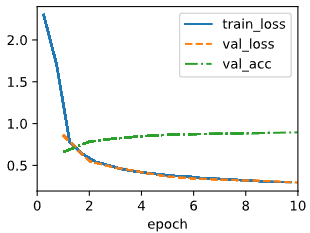

## 8.6. Residual Networks (ResNet) and ResNeXt

As we design ever deeper networks it becomes imperative to understand how adding layers can increase the complexity and expressiveness of the network. Even more important is the ability to design networks where adding layers makes networks strictly more expressive rather than just different. To make some progress we need a bit of mathematics.

In [7]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

### 8.6.1. Function Classes

Consider $\mathcal{F}$, the class of functions that a specific network architecture (together with learning rates and other hyperparameter settings) can reach.
That is, for all $f \in \mathcal{F}$ there exists some set of parameters (e.g., weights and biases) that can be obtained through training on a suitable dataset.
Let's assume that $f^*$ is the "truth" function that we really would like to find.
If it is in $\mathcal{F}$, we are in good shape but typically we will not be quite so lucky.
Instead, we will try to find some $f^*_\mathcal{F}$ which is our best bet within $\mathcal{F}$.
For instance,
given a dataset with features $\mathbf{X}$
and labels $\mathbf{y}$,
we might try finding it by solving the following optimization problem:

$$f^*_\mathcal{F} \stackrel{\textrm{def}}{=} \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \textrm{ subject to } f \in \mathcal{F}.$$

We know that regularization :cite:`tikhonov1977solutions,morozov2012methods` may control complexity of $\mathcal{F}$
and achieve consistency, so a larger size of training data
generally leads to better $f^*_\mathcal{F}$.
It is only reasonable to assume that if we design a different and more powerful architecture $\mathcal{F}'$ we should arrive at a better outcome. In other words, we would expect that $f^*_{\mathcal{F}'}$ is "better" than $f^*_{\mathcal{F}}$. However, if $\mathcal{F} \not\subseteq \mathcal{F}'$ there is no guarantee that this should even happen. In fact, $f^*_{\mathcal{F}'}$ might well be worse.
As illustrated by :numref:`fig_functionclasses`,
for non-nested function classes, a larger function class does not always move closer to the "truth" function $f^*$. For instance,
on the left of :numref:`fig_functionclasses`,
though $\mathcal{F}_3$ is closer to $f^*$ than $\mathcal{F}_1$, $\mathcal{F}_6$ moves away and there is no guarantee that further increasing the complexity can reduce the distance from $f^*$.
With nested function classes
where $\mathcal{F}_1 \subseteq \cdots \subseteq \mathcal{F}_6$
on the right of :numref:`fig_functionclasses`,
we can avoid the aforementioned issue from the non-nested function classes.


![For non-nested function classes, a larger (indicated by area) function class does not guarantee we will get closer to the "truth" function ($\mathit{f}^*$). This does not happen in nested function classes.](http://d2l.ai/_images/functionclasses.svg)

Thus,
only if larger function classes contain the smaller ones are we guaranteed that increasing them strictly increases the expressive power of the network.
For deep neural networks,
if we can
train the newly-added layer into an identity function $f(\mathbf{x}) = \mathbf{x}$, the new model will be as effective as the original model. As the new model may get a better solution to fit the training dataset, the added layer might make it easier to reduce training errors.

This is the question that :citet:`He.Zhang.Ren.ea.2016` considered when working on very deep computer vision models.
At the heart of their proposed *residual network* (*ResNet*) is the idea that every additional layer should
more easily
contain the identity function as one of its elements.
These considerations are rather profound but they led to a surprisingly simple
solution, a *residual block*.
With it, ResNet won the ImageNet Large Scale Visual Recognition Challenge in 2015. The design had a profound influence on how to
build deep neural networks. For instance, residual blocks have been added to recurrent networks :cite:`prakash2016neural,kim2017residual`. Likewise, Transformers :cite:`Vaswani.Shazeer.Parmar.ea.2017` use them to stack many layers of networks efficiently. It is also used in graph neural networks :cite:`Kipf.Welling.2016` and, as a basic concept, it has been used extensively in computer vision :cite:`Redmon.Farhadi.2018,Ren.He.Girshick.ea.2015`.
Note that residual networks are predated by highway networks :cite:`srivastava2015highway` that share some of the motivation, albeit without the elegant parametrization around the identity function.

### 8.6.2. Residual Blocks

Let's focus on a local part of a neural network, as depicted in :numref:`fig_residual_block`. Denote the input by $\mathbf{x}$.
We assume that $f(\mathbf{x})$, the desired underlying mapping we want to obtain by learning, is to be used as input to the activation function on the top.
On the left,
the portion within the dotted-line box
must directly learn $f(\mathbf{x})$.
On the right,
the portion within the dotted-line box
needs to
learn the *residual mapping* $g(\mathbf{x}) = f(\mathbf{x}) - \mathbf{x}$,
which is how the residual block derives its name.
If the identity mapping $f(\mathbf{x}) = \mathbf{x}$ is the desired underlying mapping,
the residual mapping amounts to $g(\mathbf{x}) = 0$ and it is thus easier to learn:
we only need to push the weights and biases
of the
upper weight layer (e.g., fully connected layer and convolutional layer)
within the dotted-line box
to zero.
The right figure illustrates the *residual block* of ResNet,
where the solid line carrying the layer input
$\mathbf{x}$ to the addition operator
is called a *residual connection* (or *shortcut connection*).
With residual blocks, inputs can
forward propagate faster through the residual connections across layers.
In fact,
the residual block
can be thought of as
a special case of the multi-branch Inception block:
it has two branches
one of which is the identity mapping.


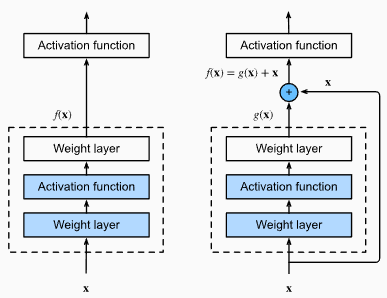

ResNet has VGG's full $3\times 3$ convolutional layer design. The residual block has two $3\times 3$ convolutional layers with the same number of output channels. Each convolutional layer is followed by a batch normalization layer and a ReLU activation function. Then, we skip these two convolution operations and add the input directly before the final ReLU activation function.
This kind of design requires that the output of the two convolutional layers has to be of the same shape as the input, so that they can be added together. If we want to change the number of channels, we need to introduce an additional $1\times 1$ convolutional layer to transform the input into the desired shape for the addition operation. Let's have a look at the code below.

In [8]:
class Residual(nn.Module):
    """The Residual block of ResNet models."""
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

This code generates two types of networks: one where we add the input to the output before applying the ReLU nonlinearity whenever use_1x1conv=False; and one where we adjust channels and resolution by means of a
 convolution before adding. Fig. 8.6.3 illustrates this.

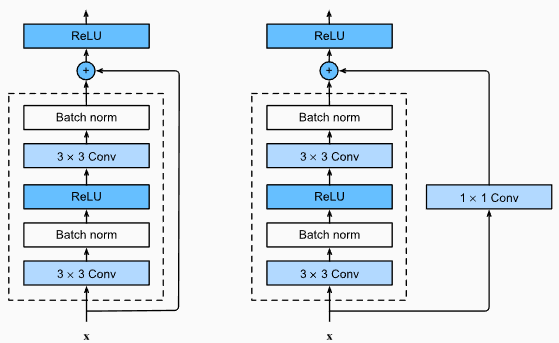

Now let's look at **a situation where the input and output are of the same shape**, where $1 \times 1$ convolution is not needed.

In [9]:
blk = Residual(3)
X = torch.randn(4, 3, 6, 6)
blk(X).shape

torch.Size([4, 3, 6, 6])

We also have the option to **halve the output height and width while increasing the number of output channels**.
In this case we use $1 \times 1$ convolutions via `use_1x1conv=True`. This comes in handy at the beginning of each ResNet block to reduce the spatial dimensionality via `strides=2`.


In [10]:
blk = Residual(6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

### 8.6.3. ResNet Model

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the $7\times 7$ convolutional layer with 64 output channels and a stride of 2 is followed by the $3\times 3$ max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [11]:
class ResNet(d2l.Classifier):
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet uses four modules made up of Inception blocks. However, ResNet uses four modules made up of residual blocks, each of which uses several residual blocks with the same number of output channels. The number of channels in the first module is the same as the number of input channels. Since a max-pooling layer with a stride of 2 has already been used, it is not necessary to reduce the height and width. In the first residual block for each of the subsequent modules, the number of channels is doubled compared with that of the previous module, and the height and width are halved.

In [12]:
@d2l.add_to_class(ResNet)
def block(self, num_residuals, num_channels, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels))
    return nn.Sequential(*blk)

Then, we add all the modules to ResNet. Here, two residual blocks are used for each module. Lastly, just like GoogLeNet, we add a global average pooling layer, followed by the fully connected layer output.

In [13]:
@d2l.add_to_class(ResNet)
def __init__(self, arch, lr=0.1, num_classes=10):
    super(ResNet, self).__init__()
    self.save_hyperparameters()
    self.net = nn.Sequential(self.b1())
    for i, b in enumerate(arch):
        self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
    self.net.add_module('last', nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
        nn.LazyLinear(num_classes)))
    self.net.apply(d2l.init_cnn)

There are four convolutional layers in each module (excluding the $1\times 1$ convolutional layer). Together with the first $7\times 7$ convolutional layer and the final fully connected layer, there are 18 layers in total. Therefore, this model is commonly known as ResNet-18.
By configuring different numbers of channels and residual blocks in the module, we can create different ResNet models, such as the deeper 152-layer ResNet-152. Although the main architecture of ResNet is similar to that of GoogLeNet, ResNet's structure is simpler and easier to modify. All these factors have resulted in the rapid and widespread use of ResNet. :numref:`fig_resnet18` depicts the full ResNet-18.

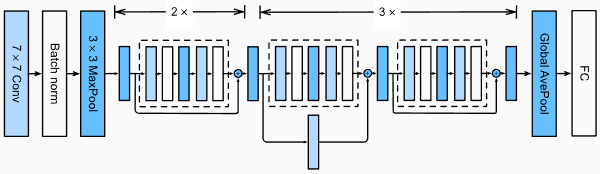

Before training ResNet, let's [**observe how the input shape changes across different modules in ResNet**]. As in all the previous architectures, the resolution decreases while the number of channels increases up until the point where a global average pooling layer aggregates all features.

In [14]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                       lr, num_classes)

ResNet18().layer_summary((1, 1, 96, 96))

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 128, 12, 12])
Sequential output shape:	 torch.Size([1, 256, 6, 6])
Sequential output shape:	 torch.Size([1, 512, 3, 3])
Sequential output shape:	 torch.Size([1, 10])


### 8.6.4. Training

We train ResNet on the Fashion-MNIST dataset, just like before. ResNet is quite a powerful and flexible architecture. The plot capturing training and validation loss illustrates a significant gap between both graphs, with the training loss being considerably lower. For a network of this flexibility, more training data would offer distinct benefit in closing the gap and improving accuracy.

In [ ]:
model = ResNet18(lr=0.01)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(96, 96))
model.apply_init([next(iter(data.get_dataloader(True)))[0]], d2l.init_cnn)
trainer.fit(model, data)

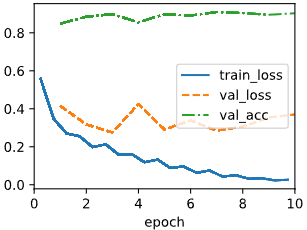

# Discussions & Exercises

### 8.2. Discussion

**The VGG network**, developed by the Visual Geometry Group (VGG) at Oxford, introduced the concept of blocks in deep neural networks. While early networks like AlexNet designed layers individually, VGG utilized blocks of layers, repeating patterns that could be reused. These blocks consist of:

1. Multiple convolutional layers with 3×3 kernels, which maintain spatial resolution through padding.
2. ReLU activation functions after each convolution to introduce nonlinearity.
3. Max-pooling layers that downsample the feature maps, reducing the spatial resolution.

The advantage of stacking smaller convolutional filters is that they allow for deeper networks without drastically increasing the number of parameters. For example, two 3×3 convolutions cover the same receptive field as one 5×5 convolution but use fewer parameters, allowing for more complex feature extraction with greater depth.

In VGG networks, these blocks are stacked in increasing depth, with channels doubling after each block, allowing for better performance on complex tasks. The final layers are fully connected layers that process the features extracted by the convolutional blocks.

### 8.2. Exercises & My Own Experiments

Epoch 1/10, Loss: 2.3031, Test Accuracy: 0.1000
Epoch 2/10, Loss: 1.3758, Test Accuracy: 0.8077
Epoch 3/10, Loss: 0.3810, Test Accuracy: 0.8832
Epoch 4/10, Loss: 0.2998, Test Accuracy: 0.8859
Epoch 5/10, Loss: 0.2533, Test Accuracy: 0.9081
Epoch 6/10, Loss: 0.2242, Test Accuracy: 0.9179
Epoch 7/10, Loss: 0.1994, Test Accuracy: 0.9150
Epoch 8/10, Loss: 0.1795, Test Accuracy: 0.9216
Epoch 9/10, Loss: 0.1615, Test Accuracy: 0.9263
Epoch 10/10, Loss: 0.1438, Test Accuracy: 0.9220
Training finished!


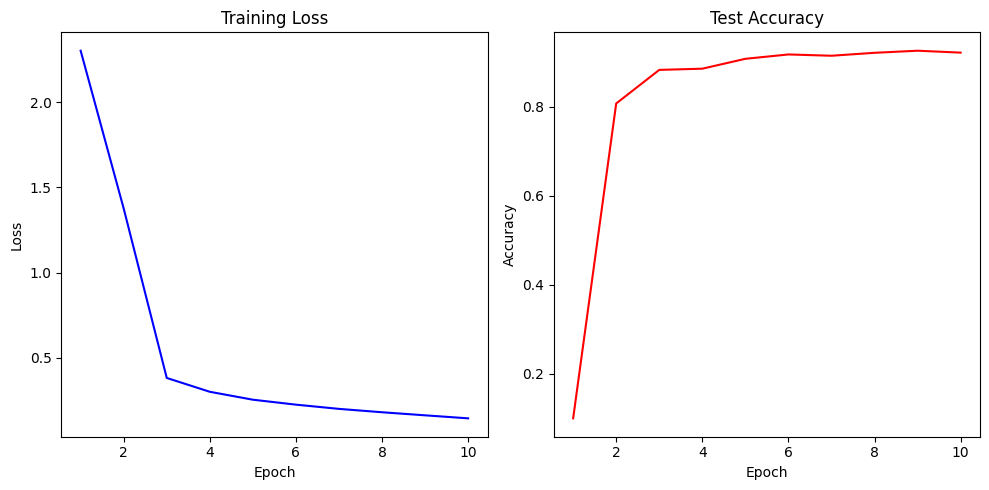

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# VGG Block 정의
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

# VGG 네트워크 정의
class VGG(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(VGG, self).__init__()
        self.features = self._make_layers(arch)
        self.classifier = nn.Sequential(
            nn.Linear(128 * 7 * 7, 4096),  # 128은 마지막 VGG 블록의 출력 채널 수
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, arch):
        layers = []
        in_channels = 1  # Fashion-MNIST는 그레이스케일 이미지
        for x in arch:
            out_channels = x[1]
            layers += [vgg_block(x[0], in_channels, out_channels)]
            in_channels = out_channels
        return nn.Sequential(*layers)

# 데이터 로딩 및 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 모델, 손실 함수, 옵티마이저 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128), (2, 128))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 학습 함수
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# 평가 함수
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return correct / total

# 학습 및 평가
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_accuracy = evaluate(model, test_loader, device)
    train_losses.append(train_loss)
    test_accuracies.append(test_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training finished!")

# 결과 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, 'b-')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, 'r-')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

### 8.6. Discussion

Residual Networks (ResNet) introduced a key idea in deep learning: adding layers should increase network expressiveness without hurting performance, which can happen if models become harder to train. The core of ResNet is the residual block, where the network learns the residual mapping instead of the original function directly. This means that, instead of learning f(x), ResNet learns g(x) = f(x) - x. When the desired function is close to the identity, this becomes easier, allowing the network to propagate gradients better and train deeper layers.

**ResNet** uses **skip connections** (shortcut connections) where inputs skip a few layers and are directly added to the output, ensuring that layers can easily learn identity functions. This idea is pivotal in stabilizing the training of very deep networks and has been highly influential in architectures such as Transformers and Graph Neural Networks (GNNs).

1. **Residual Block:** Learns residual functions instead of the full function, with skip connections helping to stabilize training.
2. **Shortcut connections:** Enables fast gradient flow through deep networks.
3. **Applications:** Transformers, Graph Neural Networks, and computer vision.

### 8.6. Exercises & My Own Experiments

100%|██████████| 26421880/26421880 [00:03<00:00, 7782215.66it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 201876.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3771301.18it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6929485.56it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10], Train Loss: 0.3788, Test Accuracy: 87.95%
Epoch [2/10], Train Loss: 0.2277, Test Accuracy: 89.00%
Epoch [3/10], Train Loss: 0.1800, Test Accuracy: 91.55%
Epoch [4/10], Train Loss: 0.1477, Test Accuracy: 91.27%
Epoch [5/10], Train Loss: 0.1192, Test Accuracy: 92.38%
Epoch [6/10], Train Loss: 0.0962, Test Accuracy: 92.22%
Epoch [7/10], Train Loss: 0.0794, Test Accuracy: 92.43%
Epoch [8/10], Train Loss: 0.0623, Test Accuracy: 91.99%
Epoch [9/10], Train Loss: 0.0496, Test Accuracy: 91.92%
Epoch [10/10], Train Loss: 0.0394, Test Accuracy: 92.74%


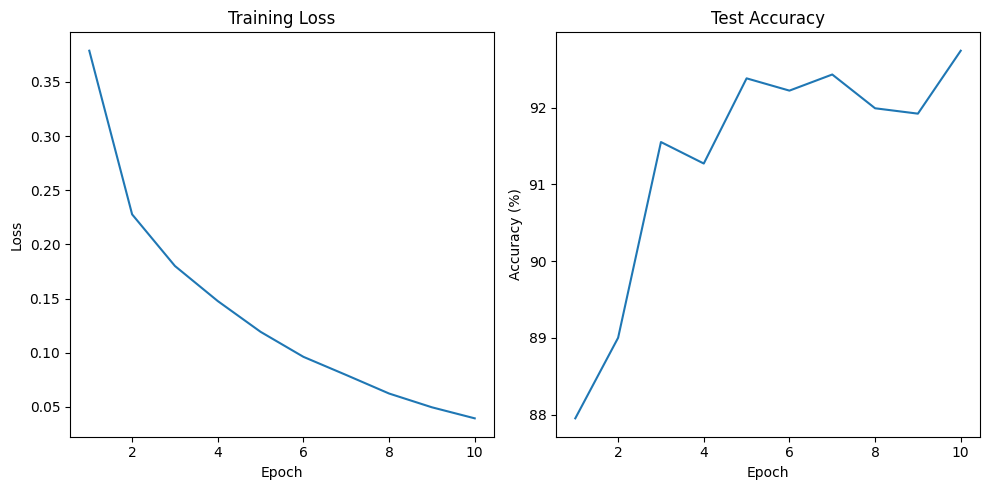

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the Residual block
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, stride=1):
        super(Residual, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)
        else:
            self.conv3 = None

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        if self.conv3:
            x = self.conv3(x)
        return F.relu(y + x)

# Define the ResNet18 model
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.b2 = self.block(64, 64, 2, first_block=True)
        self.b3 = self.block(64, 128, 2)
        self.b4 = self.block(128, 256, 2)
        self.b5 = self.block(256, 512, 2)
        self.fc = nn.Linear(512, num_classes)

    def block(self, in_channels, out_channels, num_residuals, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channels, out_channels, use_1x1conv=True, stride=2))
            else:
                blk.append(Residual(out_channels, out_channels))
        return nn.Sequential(*blk)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = self.b4(x)
        x = self.b5(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Set up data loaders
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')

plt.tight_layout()
plt.show()